In [1]:
!pip install timm

^C


In [8]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip cache purge

Defaulting to user installation because normal site-packages is not writeable


Files removed: 0


## Load and Preprocess Data

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import shutil

# Define paths to your dataset
base_dir = "C:\\Users\\sirin\\Desktop\\newhandpd\\data"
healthy_dir = os.path.join(base_dir, 'data_healthy')
sick_dir = os.path.join(base_dir, 'data_sick')

# Define the image size and batch size
image_size = (299, 299)  # As required by InceptionV4
batch_size = 16
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

# Create new directories for splits
split_base_dir = "C:\\Users\\sirin\\Desktop\\newhandpd\\data_splits"
train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Class-specific subdirectories
for split in ['train', 'val', 'test']:
    for class_name in ['Healthy', 'Sick']:
        os.makedirs(os.path.join(split_base_dir, split, class_name), exist_ok=True)

# Function to safely process images and split data
def safe_split_and_copy(source_dir, class_name, target_dirs, split_ratios):
    """
    Process images in the source directory, validate them, and split into train, val, and test.

    Args:
        source_dir (str): Path to the original dataset directory.
        class_name (str): Name of the class (e.g., 'Healthy', 'Sick').
        target_dirs (dict): Dictionary containing paths for train, val, and test directories.
        split_ratios (tuple): Ratios for splitting (train, val, test).
    """
    # Collect valid image file paths
    valid_files = []
    for root, _, files in os.walk(source_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if os.path.splitext(file)[-1].lower() not in valid_extensions:
                print(f"Removing non-image file: {file_path}")
                os.remove(file_path)
                continue

            try:
                with Image.open(file_path) as img:
                    img.verify()
                valid_files.append(file_path)
            except (UnidentifiedImageError, IOError):
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)

    # Split data
    train_files, test_files = train_test_split(valid_files, test_size=(split_ratios[1] + split_ratios[2]), random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)

    # Copy files to corresponding directories
    for file_list, target_dir in zip([train_files, val_files, test_files], [target_dirs["train"], target_dirs["val"], target_dirs["test"]]):
        target_class_dir = os.path.join(target_dir, class_name)
        for file_path in file_list:
            shutil.copy(file_path, target_class_dir)

# Split and organize data for both classes
safe_split_and_copy(healthy_dir, 'Healthy', {"train": train_dir, "val": val_dir, "test": test_dir}, (0.6, 0.2, 0.2))
safe_split_and_copy(sick_dir, 'Sick', {"train": train_dir, "val": val_dir, "test": test_dir}, (0.6, 0.2, 0.2))

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# If you want to visualize the class labels
print("Train class indices:", train_generator.class_indices)
print("Validation class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)


Found 356 images belonging to 2 classes.
Found 119 images belonging to 2 classes.
Found 119 images belonging to 2 classes.
Train class indices: {'Healthy': 0, 'Sick': 1}
Validation class indices: {'Healthy': 0, 'Sick': 1}
Test class indices: {'Healthy': 0, 'Sick': 1}


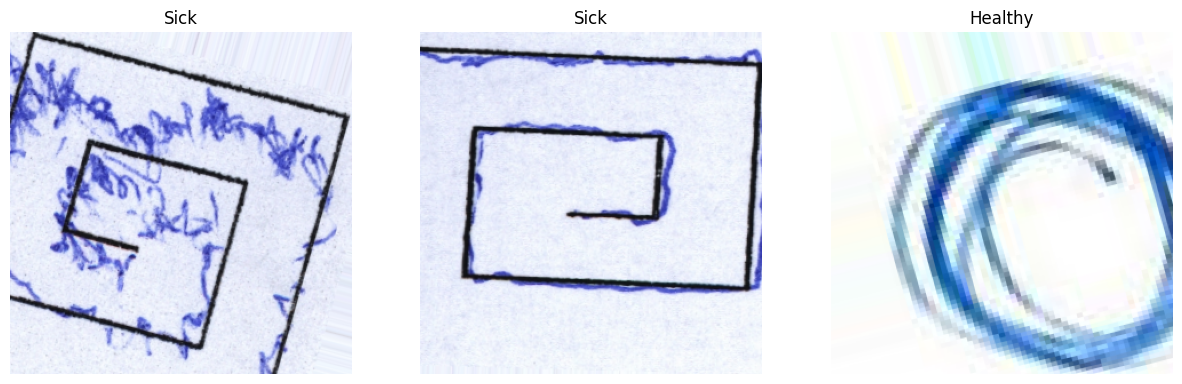

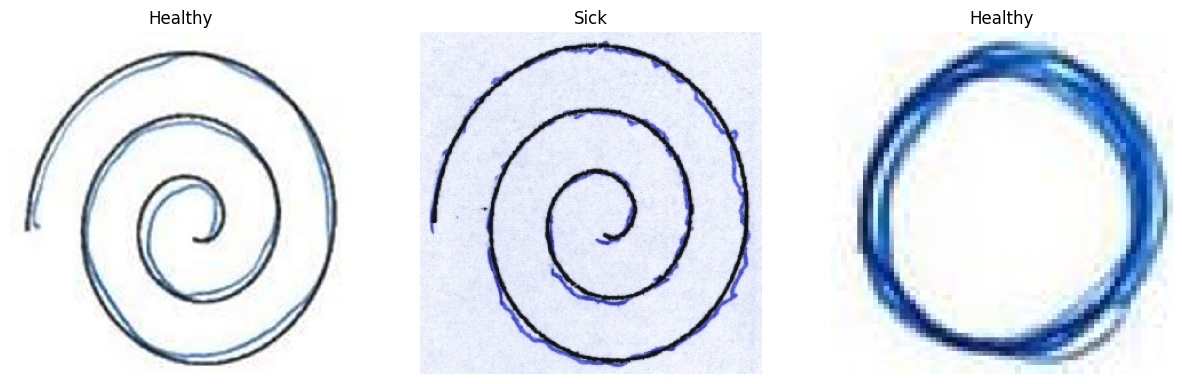

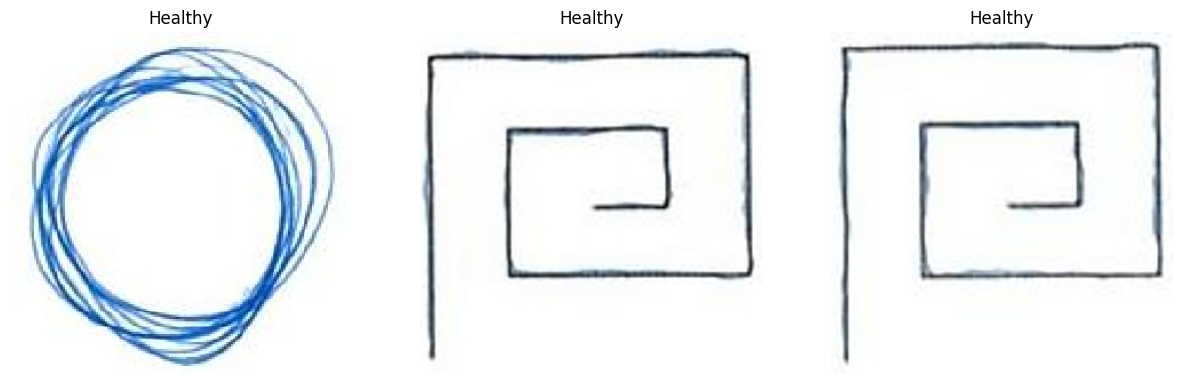

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample_images(generator, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image, label = next(generator)  # Get a batch of images
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0])  # Show the first image of the batch
        plt.title(class_names[int(label[0])])  # Convert label to integer index
        plt.axis('off')
    plt.show()

# Visualize a sample of images from the train set
visualize_sample_images(train_generator, ['Healthy', 'Sick'], 3)
visualize_sample_images(val_generator, ['Healthy', 'Sick'], 3)
visualize_sample_images(test_generator, ['Healthy', 'Sick'], 3)

## InceptionV4 feature extraction 

In [2]:
import os
import joblib
from tqdm import tqdm
from PIL import Image
from PIL import Image
import torch
import timm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from torchvision import transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('inception_v4', pretrained=True)
model.eval().to(device)
output_path = "C:\\Users\\sirin\\Desktop\\newhandpd\\data"
# Calculate steps for each generator
train_steps = len(train_generator)  # Number of batches = Total images / Batch size
val_steps = len(val_generator)
test_steps = len(test_generator)


C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define image preprocessing for InceptionV4
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Extract features from an image
def extract_features(model, image):
    with torch.no_grad():
        image_tensor = transform(image).unsqueeze(0).to(device)
        features = model.forward_features(image_tensor)
        return features.squeeze().cpu().numpy()

# Convert numpy.ndarray to PIL.Image
def numpy_to_pil(image_np):
    return Image.fromarray(image_np.astype('uint8'), 'RGB')

In [5]:




def extract_features_and_save(generator, model, transform, output_path, total_steps):
    os.makedirs(output_path, exist_ok=True)

    for i in tqdm(range(total_steps), desc="Extracting features"):
        batch_images, batch_labels = next(generator)  # Get the next batch
        batch_features = []

        for image_np in batch_images:
            image = Image.fromarray((image_np * 255).astype('uint8'))
            feature = extract_features(model, image)  # Extract features
            batch_features.append(feature)

        batch_filename = os.path.join(output_path, f"batch_{i}.pkl")
        joblib.dump((np.array(batch_features), batch_labels), batch_filename)
        print(f"Saved batch {i} to {batch_filename}")

In [6]:
# Extract and save features for train, validation, and test sets
extract_features_and_save(train_generator, model, transform, "train_features", total_steps=train_steps)
extract_features_and_save(val_generator, model, transform, "val_features", total_steps=val_steps)
extract_features_and_save(test_generator, model, transform, "test_features", total_steps=test_steps)

Extracting features:   4%|▍         | 1/23 [00:08<03:06,  8.46s/it]

Saved batch 0 to train_features\batch_0.pkl


Extracting features:   9%|▊         | 2/23 [00:16<02:52,  8.21s/it]

Saved batch 1 to train_features\batch_1.pkl


Extracting features:  13%|█▎        | 3/23 [00:24<02:45,  8.25s/it]

Saved batch 2 to train_features\batch_2.pkl


Extracting features:  17%|█▋        | 4/23 [00:37<03:12, 10.12s/it]

Saved batch 3 to train_features\batch_3.pkl


Extracting features:  22%|██▏       | 5/23 [00:45<02:49,  9.41s/it]

Saved batch 4 to train_features\batch_4.pkl


Extracting features:  26%|██▌       | 6/23 [00:53<02:30,  8.87s/it]

Saved batch 5 to train_features\batch_5.pkl


Extracting features:  30%|███       | 7/23 [01:01<02:16,  8.51s/it]

Saved batch 6 to train_features\batch_6.pkl


Extracting features:  35%|███▍      | 8/23 [01:09<02:06,  8.40s/it]

Saved batch 7 to train_features\batch_7.pkl


Extracting features:  39%|███▉      | 9/23 [01:17<01:56,  8.33s/it]

Saved batch 8 to train_features\batch_8.pkl


Extracting features:  43%|████▎     | 10/23 [01:26<01:48,  8.32s/it]

Saved batch 9 to train_features\batch_9.pkl


Extracting features:  48%|████▊     | 11/23 [01:34<01:39,  8.31s/it]

Saved batch 10 to train_features\batch_10.pkl


Extracting features:  52%|█████▏    | 12/23 [01:42<01:32,  8.37s/it]

Saved batch 11 to train_features\batch_11.pkl


Extracting features:  57%|█████▋    | 13/23 [01:50<01:22,  8.25s/it]

Saved batch 12 to train_features\batch_12.pkl


Extracting features:  61%|██████    | 14/23 [01:59<01:15,  8.37s/it]

Saved batch 13 to train_features\batch_13.pkl


Extracting features:  65%|██████▌   | 15/23 [02:07<01:07,  8.38s/it]

Saved batch 14 to train_features\batch_14.pkl


Extracting features:  70%|██████▉   | 16/23 [02:15<00:57,  8.20s/it]

Saved batch 15 to train_features\batch_15.pkl


Extracting features:  74%|███████▍  | 17/23 [02:23<00:48,  8.09s/it]

Saved batch 16 to train_features\batch_16.pkl


Extracting features:  78%|███████▊  | 18/23 [02:31<00:39,  7.93s/it]

Saved batch 17 to train_features\batch_17.pkl


Extracting features:  83%|████████▎ | 19/23 [02:39<00:31,  7.97s/it]

Saved batch 18 to train_features\batch_18.pkl


Extracting features:  87%|████████▋ | 20/23 [02:46<00:23,  7.88s/it]

Saved batch 19 to train_features\batch_19.pkl


Extracting features:  91%|█████████▏| 21/23 [02:54<00:15,  7.78s/it]

Saved batch 20 to train_features\batch_20.pkl


Extracting features:  96%|█████████▌| 22/23 [03:02<00:07,  7.82s/it]

Saved batch 21 to train_features\batch_21.pkl


Extracting features: 100%|██████████| 23/23 [03:04<00:00,  8.02s/it]


Saved batch 22 to train_features\batch_22.pkl


Extracting features:  12%|█▎        | 1/8 [00:07<00:51,  7.37s/it]

Saved batch 0 to val_features\batch_0.pkl


Extracting features:  25%|██▌       | 2/8 [00:14<00:44,  7.46s/it]

Saved batch 1 to val_features\batch_1.pkl


Extracting features:  38%|███▊      | 3/8 [00:22<00:37,  7.42s/it]

Saved batch 2 to val_features\batch_2.pkl


Extracting features:  50%|█████     | 4/8 [00:29<00:29,  7.41s/it]

Saved batch 3 to val_features\batch_3.pkl


Extracting features:  62%|██████▎   | 5/8 [00:36<00:22,  7.38s/it]

Saved batch 4 to val_features\batch_4.pkl


Extracting features:  75%|███████▌  | 6/8 [00:44<00:14,  7.35s/it]

Saved batch 5 to val_features\batch_5.pkl


Extracting features:  88%|████████▊ | 7/8 [00:51<00:07,  7.34s/it]

Saved batch 6 to val_features\batch_6.pkl


Extracting features: 100%|██████████| 8/8 [00:54<00:00,  6.86s/it]


Saved batch 7 to val_features\batch_7.pkl


Extracting features:  12%|█▎        | 1/8 [00:07<00:50,  7.17s/it]

Saved batch 0 to test_features\batch_0.pkl


Extracting features:  25%|██▌       | 2/8 [00:14<00:42,  7.12s/it]

Saved batch 1 to test_features\batch_1.pkl


Extracting features:  38%|███▊      | 3/8 [00:21<00:35,  7.09s/it]

Saved batch 2 to test_features\batch_2.pkl


Extracting features:  50%|█████     | 4/8 [00:28<00:28,  7.16s/it]

Saved batch 3 to test_features\batch_3.pkl


Extracting features:  62%|██████▎   | 5/8 [00:35<00:21,  7.18s/it]

Saved batch 4 to test_features\batch_4.pkl


Extracting features:  75%|███████▌  | 6/8 [00:43<00:14,  7.35s/it]

Saved batch 5 to test_features\batch_5.pkl


Extracting features:  88%|████████▊ | 7/8 [00:50<00:07,  7.32s/it]

Saved batch 6 to test_features\batch_6.pkl


Extracting features: 100%|██████████| 8/8 [00:54<00:00,  6.75s/it]

Saved batch 7 to test_features\batch_7.pkl


In [7]:
def extract_features_and_collect(generator, model, transform, total_steps):
    """
    Extracts features and labels from a generator and collects them in lists.

    Args:
        generator: Data generator.
        model: Feature extraction model.
        transform: Image transformation function.
        total_steps: Total number of steps (batches) in the generator.

    Returns:
        A tuple containing:
        - all_features: A list of feature arrays.
        - all_labels: A list of labels.
    """

    all_features = []
    all_labels = []

    for _ in tqdm(range(total_steps), desc="Extracting features"):  # Use _ for unused loop variable
        batch_images, batch_labels = next(generator)
        batch_features = []

        for image_np in batch_images:
            image = Image.fromarray((image_np * 255).astype('uint8'))
            feature = extract_features(model, image)  # Your feature extraction function
            batch_features.append(feature)

        all_features.extend(batch_features)  # Extend to add individual features
        all_labels.extend(batch_labels)

    return np.array(all_features), np.array(all_labels)


# Example usage:
# Assuming you have train_generator, val_generator, test_generator, model, and transform defined

train_features, train_labels = extract_features_and_collect(train_generator, model, transform, train_steps)
val_features, val_labels = extract_features_and_collect(val_generator, model, transform, val_steps)
test_features, test_labels = extract_features_and_collect(test_generator, model, transform, test_steps)

# Now you have the features and labels in memory as NumPy arrays:
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Validation features shape:", val_features.shape)
print("Validation labels shape:", val_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)


Extracting features: 100%|██████████| 8/8 [00:50<00:00,  6.30s/it]

Train features shape: (356, 1536, 8, 8)
Train labels shape: (356,)
Validation features shape: (119, 1536, 8, 8)
Validation labels shape: (119,)
Test features shape: (119, 1536, 8, 8)
Test labels shape: (119,)


In [8]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached imageio-2.36.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2024.9.20-py3-none-any.whl.metadata (32 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 4.8 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/12.9 MB 3.1 MB/s eta 0:00:04
   ---- ----------------------------------- 1.6/12.9 MB 2.5 MB/s eta 0:00:05
   ----- ---------------------------------- 1.8/12.9 MB 2.3 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/12.9 MB 2.3 MB/s eta 0:00:05
   -------- ------------------------------- 2.6/12.9 MB 2.1 MB/s eta 0:00:05
   -------- ------------------------------- 2.9/12.9 MB 2.0 MB/s eta 0:00:05
   ---------- ----------------------

In [8]:
from skimage.feature import local_binary_pattern

def lbp_features(image, P=8, R=1):
    """
    Calculates Local Binary Patterns (LBP) for an image.

    Args:
        image: Input image as a NumPy array (H x W x C).
        P: Number of circularly symmetric neighbors.
        R: Radius of the circle.

    Returns:
        LBP image as a NumPy array.
    """
    lbp_image = local_binary_pattern(image, P, R, method="uniform")
    return lbp_image.flatten()

def extract_lbp_features(generator, total_steps):
    all_lbp_features = []
    all_labels = []

    for i in tqdm(range(total_steps), desc="Extracting LBP features"):
        batch_images, batch_labels = next(generator)
        batch_lbp_features = []

        for image_np in batch_images:
            image = Image.fromarray((image_np * 255).astype('uint8'))
            gray_image = image.convert('L') 
            gray_np = np.array(gray_image)
            lbp_feature = lbp_features(gray_np)
            batch_lbp_features.append(lbp_feature)

        all_lbp_features.extend(batch_lbp_features)
        all_labels.extend(batch_labels)

    return np.array(all_lbp_features), np.array(all_labels)

# Extract LBP features for train, validation, and test sets
train_lbp_features, train_lbp_labels = extract_lbp_features(train_generator, train_steps)
val_lbp_features, val_lbp_labels = extract_lbp_features(val_generator, val_steps)
test_lbp_features, test_lbp_labels = extract_lbp_features(test_generator, test_steps)

Extracting LBP features: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


In [11]:
# Now you have the features and labels in memory as NumPy arrays:
print("Train features shape:", train_lbp_features.shape)
print("Train labels shape:", train_lbp_labels.shape)
print("Validation features shape:", val_lbp_features.shape)
print("Validation labels shape:", val_lbp_labels.shape)
print("Test features shape:", test_lbp_features.shape)
print("Test labels shape:", test_lbp_labels.shape)

Train features shape: (356, 89401)
Train labels shape: (356,)
Validation features shape: (119, 89401)
Validation labels shape: (119,)
Test features shape: (119, 89401)
Test labels shape: (119,)


In [12]:
# Apply Global Average Pooling (GAP)
train_features = np.mean(train_features, axis=(2, 3))
val_features = np.mean(val_features, axis=(2, 3))
test_features = np.mean(test_features, axis=(2, 3))
print("After GAP, train_features shape:", train_features.shape)
print("After GAP, val_features shape:", val_features.shape)
print("After GAP, val_features shape:", test_features.shape)


After GAP, train_features shape: (356, 1536)
After GAP, val_features shape: (119, 1536)
After GAP, val_features shape: (119, 1536)


In [13]:
# Combine InceptionV4 and LBP features
train_combined_features = np.concatenate((train_features, train_lbp_features), axis=1)
val_combined_features = np.concatenate((val_features, val_lbp_features), axis=1)
test_combined_features = np.concatenate((test_features, test_lbp_features), axis=1)

In [10]:
import joblib
import numpy as np
import os

def load_features_from_directory(directory):
    all_features = []
    all_labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".pkl"):
            file_path = os.path.join(directory, filename)
            features, labels = joblib.load(file_path)
            all_features.append(features)
            all_labels.append(labels)

    return np.vstack(all_features), np.hstack(all_labels)

train_features, train_labels = load_features_from_directory("train_features")
val_features, val_labels = load_features_from_directory("val_features")
test_features, test_labels = load_features_from_directory("test_features")

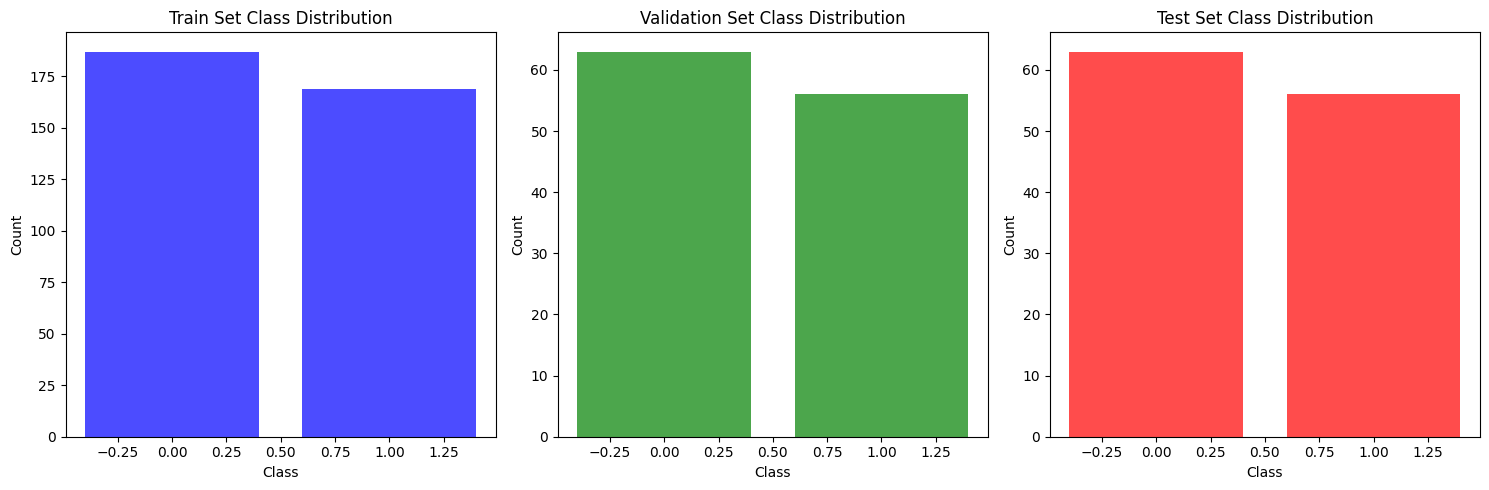

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(train_labels, val_labels, test_labels):
    # Ensure the labels are integers
    train_labels = train_labels.astype(int)
    val_labels = val_labels.astype(int)
    test_labels = test_labels.astype(int)

    # Count occurrences of each class
    train_class_counts = np.bincount(train_labels)
    val_class_counts = np.bincount(val_labels)
    test_class_counts = np.bincount(test_labels)

    # Plot class distribution
    labels = np.arange(len(train_class_counts))
    
    plt.figure(figsize=(15, 5))

    # Train set
    plt.subplot(1, 3, 1)
    plt.bar(labels, train_class_counts, color='blue', alpha=0.7)
    plt.title('Train Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Validation set
    plt.subplot(1, 3, 2)
    plt.bar(labels, val_class_counts, color='green', alpha=0.7)
    plt.title('Validation Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Test set
    plt.subplot(1, 3, 3)
    plt.bar(labels, test_class_counts, color='red', alpha=0.7)
    plt.title('Test Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Example usage
plot_class_distribution(train_labels, val_labels, test_labels)

After GAP, train_features shape: (356, 1536)
After GAP, val_features shape: (119, 1536)
After GAP, val_features shape: (119, 1536)


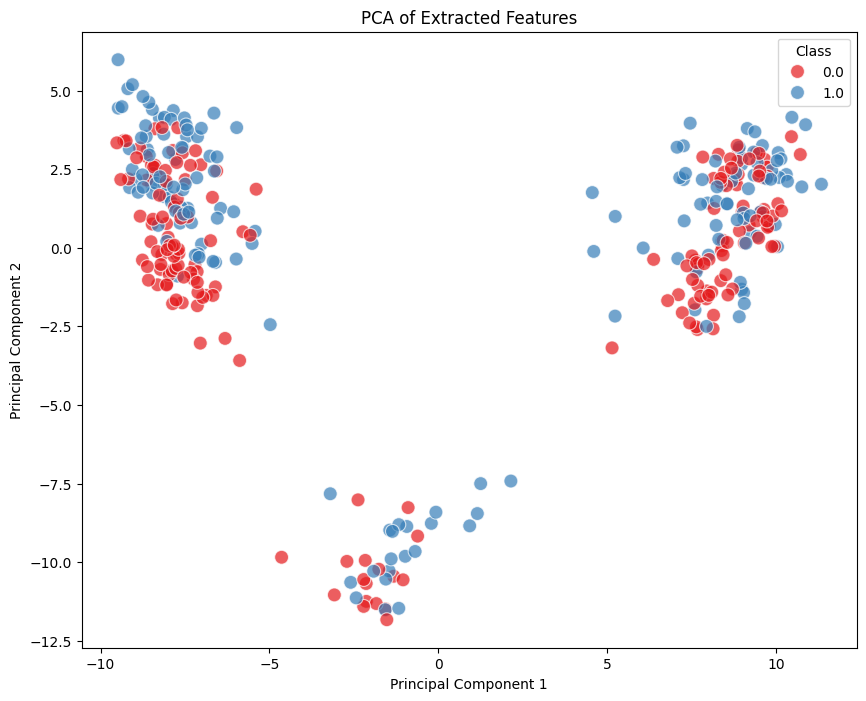

Explained Variance Ratio of the first two components: [0.4479797  0.10791581]


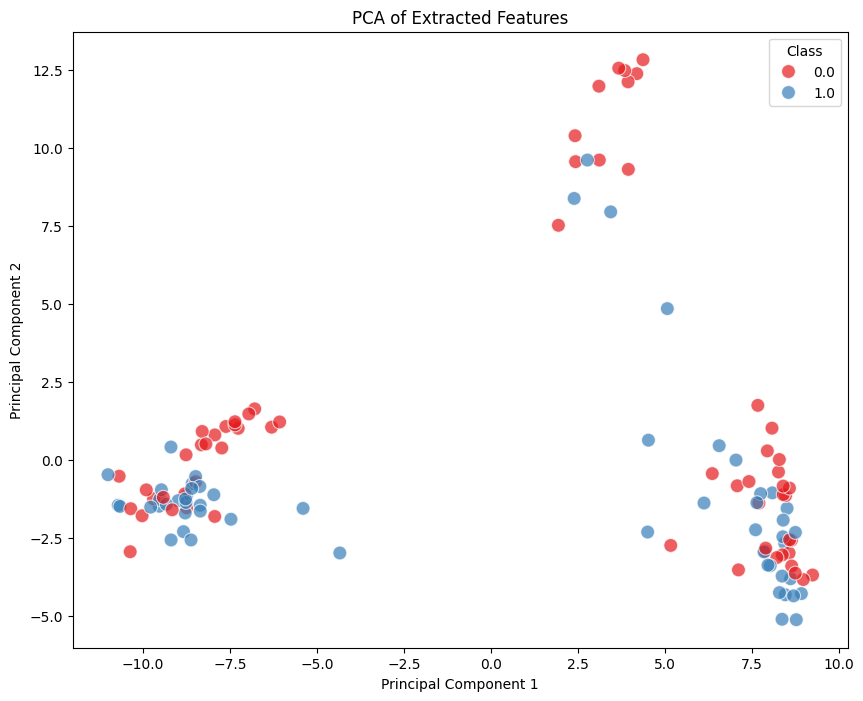

Explained Variance Ratio of the first two components: [0.50861776 0.14303733]


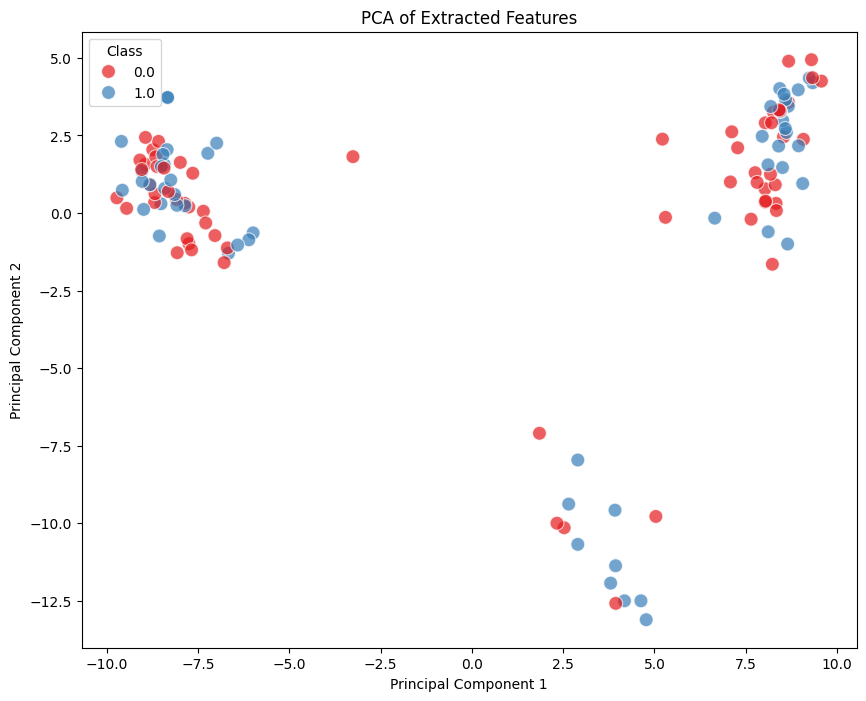

Explained Variance Ratio of the first two components: [0.47905684 0.13815022]


In [8]:
from sklearn.decomposition import PCA
import seaborn as sns

def visualize_features(features, labels):
    # Reduce the dimensionality to 2D using PCA for visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    # Plot the reduced features
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette='Set1', s=100, alpha=0.7)
    plt.title('PCA of Extracted Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Class', loc='best')
    plt.show()
    # Print explained variance ratio of the principal components
    print(f"Explained Variance Ratio of the first two components: {pca.explained_variance_ratio_}")
    

# Apply Global Average Pooling (GAP)
train_features = np.mean(train_features, axis=(2, 3))
val_features = np.mean(val_features, axis=(2, 3))
test_features = np.mean(test_features, axis=(2, 3))
print("After GAP, train_features shape:", train_features.shape)
print("After GAP, val_features shape:", val_features.shape)
print("After GAP, val_features shape:", test_features.shape)

# Visualize features after GAP
visualize_features(train_features, train_labels)
visualize_features(val_features, val_labels)
visualize_features(test_features, val_labels)

In [ ]:
# Combine InceptionV4 and LBP features
train_combined_features = np.concatenate((train_features, train_lbp_features), axis=1)
val_combined_features = np.concatenate((val_features, val_lbp_features), axis=1)
test_combined_features = np.concatenate((test_features, test_lbp_features), axis=1)

In [14]:
train_combined_features.shape

(356, 90937)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


# 1. Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_combined_features)
X_val_scaled = scaler.transform(val_combined_features)
X_test_scaled = scaler.transform(test_combined_features)

# 2. Perform Recursive Feature Elimination with Cross-Validation (RFECV)
# Define the classifier to use for RFE
clf = RandomForestClassifier(random_state=42)

# Use Stratified K-Folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define RFECV
rfecv = RFECV(
    estimator=clf,
    step=1,  # Number of features to remove at each iteration
    cv=cv,  # Cross-validation strategy
    scoring='accuracy',  # Scoring metric
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

# Fit RFECV on the training data
rfecv.fit(X_train_scaled, train_labels)

# 3. Select Important Features
# Mask of selected features
selected_features_mask = rfecv.support_

# Apply mask to training, validation, and test sets
X_train_selected = X_train_scaled[:, selected_features_mask]
X_val_selected = X_val_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# 4. Print Results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features (indices): {np.where(selected_features_mask)[0]}")
#print(f"Validation score with selected features: {rfecv.grid_scores_.max()}")

# 5. Train the Classifier with Selected Features
clf.fit(X_train_selected, train_labels)
val_score = clf.score(X_val_selected, val_labels)
test_score = clf.score(X_test_selected, test_labels)

print(f"Validation Accuracy: {val_score}")
print(f"Test Accuracy: {test_score}")


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid and RandomizedSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7],  # A broader range of neighbors
    'weights': ['uniform', 'distance'],      # Test both uniform and distance weighting
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Common distance metrics
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(train_combined_features, train_labels)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train and evaluate the best KNN model
best_knn = KNeighborsClassifier(**random_search.best_params_)
best_knn.fit(train_combined_features, train_labels)
val_accuracy = best_knn.score(val_combined_features, val_labels)
print("Validation accuracy:", val_accuracy)


# Evaluate the best KNN model on the test set
test_accuracy = best_knn.score(test_combined_features, test_labels)
print("Test set accuracy:", test_accuracy)

# Optional: Get predictions for further analysis
test_predictions = best_knn.predict(test_combined_features)

# Optional: Print confusion matrix and classification report for detailed evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


Best parameters: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
Best score: 0.5422143974960876
Validation accuracy: 0.5126050420168067
Test set accuracy: 0.5630252100840336
Confusion Matrix:
[[49 14]
 [38 18]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.78      0.65        63
         1.0       0.56      0.32      0.41        56

    accuracy                           0.56       119
   macro avg       0.56      0.55      0.53       119
weighted avg       0.56      0.56      0.54       119



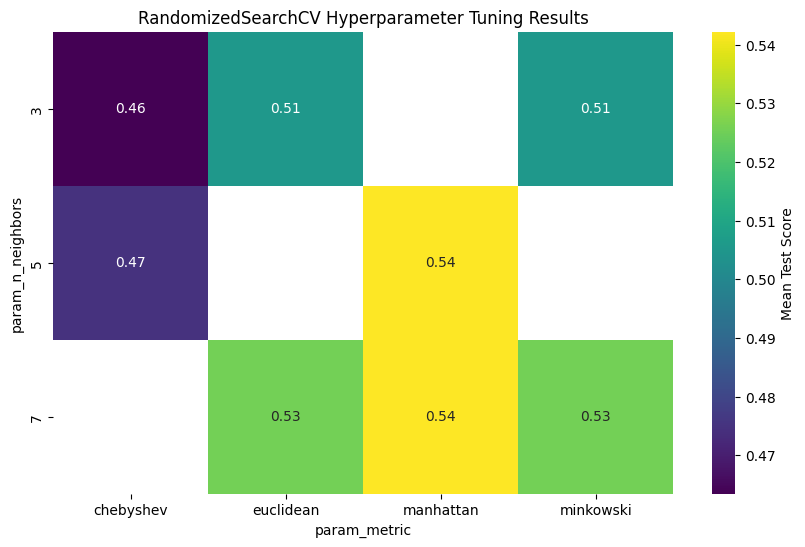

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize hyperparameter tuning results
results = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.heatmap(results.pivot_table(index='param_n_neighbors', columns='param_metric', values='mean_test_score'),
            annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Mean Test Score'})
plt.title('RandomizedSearchCV Hyperparameter Tuning Results')
plt.show()


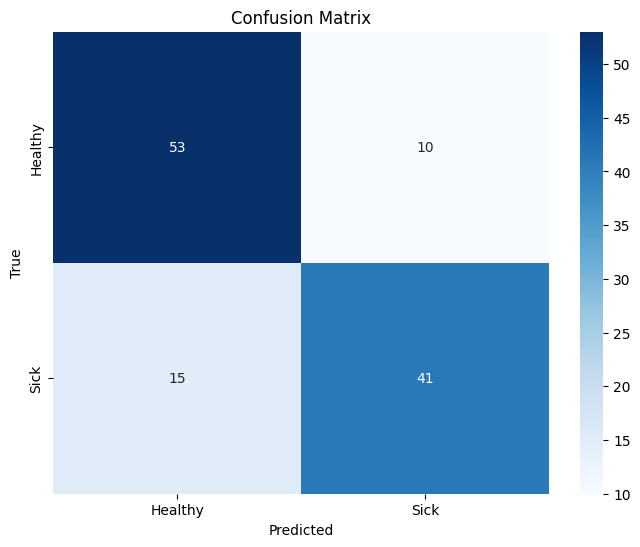

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81        63
         1.0       0.80      0.73      0.77        56

    accuracy                           0.79       119
   macro avg       0.79      0.79      0.79       119
weighted avg       0.79      0.79      0.79       119



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate confusion matrix for test set predictions
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, ['Healthy', 'Sick'])

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions))


In [14]:
import joblib
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Load features
train_features, train_labels = load_features_from_directory("train_features")
val_features, val_labels = load_features_from_directory("val_features")
test_features, test_labels = load_features_from_directory("test_features")

# Apply Global Average Pooling (GAP)
train_features = np.mean(train_features, axis=(2, 3))
val_features = np.mean(val_features, axis=(2, 3))
test_features = np.mean(test_features, axis=(2, 3))
print("After GAP, train_features shape:", train_features.shape)
print("After GAP, val_features shape:", val_features.shape)
print("After GAP, val_features shape:", test_features.shape)


# Define a function to train and evaluate different classifiers
def train_and_evaluate_classifier(classifier, param_grid, train_features, train_labels, val_features, val_labels, test_features, test_labels):
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(train_features, train_labels)
    
    print(f"Best parameters for {classifier.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {classifier.__class__.__name__}: {grid_search.best_score_}")
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Evaluate on validation set
    val_accuracy = best_model.score(val_features, val_labels)
    print(f"Validation accuracy for {classifier.__class__.__name__}: {val_accuracy}")

    # Evaluate on test set
    test_accuracy = best_model.score(test_features, test_labels)
    print(f"Test accuracy for {classifier.__class__.__name__}: {test_accuracy}")

    # Get predictions for further analysis
    test_predictions = best_model.predict(test_features)

    # Print confusion matrix and classification report
    print(f"Confusion Matrix for {classifier.__class__.__name__}:")
    print(confusion_matrix(test_labels, test_predictions))
    
    print(f"\nClassification Report for {classifier.__class__.__name__}:")
    print(classification_report(test_labels, test_predictions))

# Define parameter grids for each classifier
rf_param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],   # Minimum number of samples required to be at a leaf node
}

svm_param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']   # Kernel coefficient
}

log_reg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # More values for C
    'penalty': ['l2'],
    'solver': ['liblinear', 'newton-cg', 'saga'],  # More solvers
}


# Initialize classifiers
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42)
log_reg_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate classifiers
print("\nTraining and Evaluating Random Forest...")
train_and_evaluate_classifier(rf_classifier, rf_param_grid, train_features, train_labels, val_features, val_labels, test_features, test_labels)

print("\nTraining and Evaluating Support Vector Machine...")
train_and_evaluate_classifier(svm_classifier, svm_param_grid, train_features, train_labels, val_features, val_labels, test_features, test_labels)

print("\nTraining and Evaluating Logistic Regression...")
train_and_evaluate_classifier(log_reg_classifier, log_reg_param_grid, train_features, train_labels, val_features, val_labels, test_features, test_labels)

After GAP, train_features shape: (356, 1536)
After GAP, val_features shape: (119, 1536)
After GAP, val_features shape: (119, 1536)

Training and Evaluating Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score for RandomForestClassifier: 0.7808685446009389
Validation accuracy for RandomForestClassifier: 0.7563025210084033
Test accuracy for RandomForestClassifier: 0.7899159663865546
Confusion Matrix for RandomForestClassifier:
[[51 12]
 [13 43]]

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80        63
         1.0       0.78      0.77      0.77        56

    accuracy                           0.79       119
   macro avg       0.79      0.79      0.79       119
weighted avg       0.79      0.79      0.79  

C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: Conve

Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score for LogisticRegression: 0.7750782472613458
Validation accuracy for LogisticRegression: 0.7815126050420168
Test accuracy for LogisticRegression: 0.8403361344537815
Confusion Matrix for LogisticRegression:
[[53 10]
 [ 9 47]]

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85        63
         1.0       0.82      0.84      0.83        56

    accuracy                           0.84       119
   macro avg       0.84      0.84      0.84       119
weighted avg       0.84      0.84      0.84       119



C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Assuming you have the best models already trained (best_knn, best_rf, best_svm, best_log_reg)
# If not, train them as follows (replace with your actual models)

# Example (If you haven't already trained the models):
# For Random Forest:
best_rf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200)

# For Support Vector Machine:
best_svm = SVC(C=0.1, kernel='linear', gamma='scale')

# For Logistic Regression:
best_log_reg = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg')

# Create the ensemble classifier using VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('knn', best_knn),  # Assuming best_knn is trained and optimized
    ('rf', best_rf),    # Random Forest
    ('svm', best_svm),  # Support Vector Machine
    ('log_reg', best_log_reg)  # Logistic Regression
], voting='hard')  # 'hard' for majority voting, 'soft' for probability-based voting

# Train the ensemble classifier
ensemble.fit(train_features, train_labels)

# Evaluate the ensemble model on the test set
test_predictions = ensemble.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Ensemble Test Accuracy:", test_accuracy)

# Optional: Confusion Matrix and Classification Report for the ensemble model
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix for Ensemble:")
print(confusion_matrix(test_labels, test_predictions))

print("\nClassification Report for Ensemble:")
print(classification_report(test_labels, test_predictions))


Ensemble Test Accuracy: 0.7983193277310925
Confusion Matrix for Ensemble:
[[55  8]
 [16 40]]

Classification Report for Ensemble:
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82        63
         1.0       0.83      0.71      0.77        56

    accuracy                           0.80       119
   macro avg       0.80      0.79      0.80       119
weighted avg       0.80      0.80      0.80       119

